## Import statements

In [1]:
import pandas as pd  # for DataFrames, dataframe for time series data
import pandas_ta as ta  # !pip install pandas_ta
import numpy as np  # array,matrix,random numbers
import math
import sys
import yfinance as yf  # !pip install yfinance
from io import StringIO  # before pandas_datareader
from pandas_datareader import data as pdr
from pandas_datareader import data, wb
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib import rc, interactive
import datetime as dt
from datetime import timedelta, datetime, date, time
import time
import pathlib
from pathlib import Path  # to read/write files
import os
from os import path
import ast
import re
import requests  # scraping the web
from urllib.request import urlopen
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
import fredapi
from fredapi import Fred

InteractiveShell.ast_node_interactivity = "all"
register_matplotlib_converters()
pd.core.common.is_list_like = pd.api.types.is_list_like

#%matplotlib widget 
# to get the zoom , pan ability for the graphs

C:\Users\champ\Python_proj\main_env\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Constants and variables

In [2]:
#  Global constants
DATA_TYPE = 'Adj Close'
DAYS_LOOK_BACK = 5110  # 12*252 years expresed in days
HOW_RECENT = 0
MAIN_FOLDER = 'C:/Users/champ/Python_proj/base_financial_repo/'
META_FILE_FOLDER = 'meta_data/'
SECURITIES_FILE = 'Securities research.csv'
HOLIDAYS_FILE = 'Federal_holidays.csv'
FRED_API = '' # YOUR_API_GOES_IN_QUOTES]
FIGURE_WIDTH = 12
FIGURE_HEIGHT = 6
LINE_WIDTH = 2
GRAPH_FONT_SIZE = 12
INX = 'spy'


#  Global variables
end_date = pd.Timestamp('today')
end_date = end_date.replace(hour=0, minute=0, second=0, microsecond=0)
start_date = end_date - timedelta(days=DAYS_LOOK_BACK)
fred = Fred(FRED_API)
Securities_file_location = MAIN_FOLDER + META_FILE_FOLDER + SECURITIES_FILE
Holidays = pd.read_csv(MAIN_FOLDER + META_FILE_FOLDER +
                       HOLIDAYS_FILE, sep=',', index_col='Date')
Holidays.index = pd.to_datetime(Holidays.index, format='%m/%d/%Y')
Today = pd.Timestamp('today').normalize()
kw_save = dict(bbox_iches='tight', transparent=True)



## Functions

In [3]:
def download_data_fn(price_data, account, pnt_stmnt):
    '''
    This function validates the call for downloading pricing data by
    checking if the US markets are open and by checking if the price
    data is the latest
    '''

    download_data = False  # Initialize
    if Today.dayofweek > 4:  # Is today a sat or sun
        if Today.dayofweek == 5:  # Is today a sat
            if Today - pd.Timedelta(days=1) == price_data.index[-1]:
                if pnt_stmnt:
                    print("Today is a sat and the ")
                    print(f"{account} price data is updated")
            else:
                download_data = True
        elif Today.dayofweek == 6:  # Is today a sun
            if Today - pd.Timedelta(days=2) == price_data.index[-1]:
                if pnt_stmnt:
                    print("Today is a sun is and the ")
                    print(f"{account} price data is updated")
            else:
                download_data = True
    elif Today in Holidays.index:
        if not(Today.dayofweek == 0):
            if not(Today - pd.Timedelta(days=1) ==
                    price_data.index[-1]):
                if pnt_stmnt:
                    print("Today is not a mon holiday and the ")
                    print(f"the {account} price data is NOT updated")
                    download_data = True
            elif pnt_stmnt:
                print("Today is not a mon holiday ")
                print(f"the {account} price data is updated")
        elif not(Today-pd.Timedelta(days=3) == price_data.index[-1]):
            if pnt_stmnt:
                print("Today is a mon holiday and the ")
                print(f"the {account} price data is NOT updated")
                download_data = True
        elif pnt_stmnt:
            print("Today is a mon holiday and the ")
            print(f"{account} price data is updated")
    elif not(Today - pd.Timedelta(days=0) == price_data.index[-1]):
        download_data = True
        if pnt_stmnt:
            print("Today the market was open and the ")
            print(f"{account} price data is NOT updated")
    if not download_data and Today.dayofweek < 5 and pnt_stmnt:
        print("Today the market was open and the ")
        print(f"{account} price data is updated")
    elif not download_data and Today.dayofweek > 4 and pnt_stmnt:
        print("Today the market is CLOSED and the ")
        print(f"the {account} price data is updated")
    return(download_data)


def get_prices(securities, account, prices_file, data_type,
               start_date, force_update):
    '''
    This function downloads the pricing pricing data from Yahoo finance
    '''

    download_data = True
    pnt_stmnt = True  # Tells the weekday and whether the data needs updating
    if account == 'inx':
        pnt_stmnt = False
    if not(path.exists(prices_file)):
        open(prices_file, "w")
        download_data = True
    elif path.exists(prices_file) and os.path.getsize(prices_file) > 8000:
        price_data = pd.read_csv(prices_file, sep=';', index_col='Date')
        price_data.index = pd.to_datetime(price_data.index, format='%Y-%m-%d')
        download_data = download_data_fn(price_data, account, pnt_stmnt)
    else:
        download_data = True
    
    if download_data or force_update:
        i = 1
        print('')
        print('Downloading price data ....')
        while i < 5:
            # print('Attempts (before try)= '+str(i))
            try:
                # print('Attempts (in the try)= '+str(i))
                price_data = pd.DataFrame()
                for t in securities:
                    # print("Here")
                    if data_type == 'all':
                        price_data = pdr.get_data_yahoo(t, start=start_date)
                        # print('Here')
                    else:
                        # print('Here')
                        price_data[t] =\
                            pdr.get_data_yahoo(t, start=start_date)[data_type]   
                price_data.sort_index(inplace=True)
                price_data.to_csv(prices_file, sep=';', index=True)
                i += 1
                # print("Here")
            except Exception:
                print("failed .. reconnect .."
                    "try again ... downloading "+ t)
                i += 1
                pass

            else:
                break
        i = 1
        print('Downloading price data .... Finished')
        download_data = False
        return(price_data)
    return(price_data)


def get_FRED_data(FRED_series,
                  filename,
                  start_date,
                  data_annl_return_divisor,
                  normalization_factor,
                  API):
    '''
    This function downloads the econometric data from
    Federal Reserve Economic Data - FRED using an API
    '''

    FRED_file = MAIN_FOLDER+META_FILE_FOLDER+'FRED_data_'+filename+'.csv'
    download_data = True
    pnt_stmnt = False  # Tells the weekday and whether the ...
    # data needs is updated to the latest date
    if not(path.exists(FRED_file)):
        open(FRED_file, "w")
        download_data = True
    elif path.exists(FRED_file) and os.path.getsize(FRED_file) > 8000:
        FRED_data = pd.DataFrame()
        FRED_data = pd.read_csv(FRED_file, sep=',', names=['DATE',
                                FRED_series], dtype={'DATE': 'str',
                                FRED_series: 'str'},
                                parse_dates=['DATE'], index_col='DATE')
        FRED_data.drop(FRED_data.index[0], inplace=True)
        FRED_data.index = pd.to_datetime(FRED_data.index, format='%Y-%m-%d')
        FRED_data = FRED_data.astype(float)
        download_data = download_data_fn(FRED_data, FRED_series, pnt_stmnt)
        # if ((pd.to_datetime('today'))-FRED_data.index[-1]).days < how_recent:
        #     pass
        # else:
        #     download_data=True
    else:
        download_data = True
    if download_data and not(len(FRED_API) == 0):
        FRED_data = fred.get_series(FRED_series, start_date)
        FRED_data.to_csv(FRED_file, sep=',', header=True)
        FRED_data.index = pd.to_datetime(FRED_data.index, format='%Y-%m-d')
        FRED_data.index = pd.to_datetime(FRED_data.index, format='%m/%d/%Y')
    FRED_data = pd.read_csv(FRED_file, sep=',', names=['DATE', FRED_series],
                            dtype={'DATE': 'str', FRED_series: 'str'},
                            parse_dates=['DATE'], index_col='DATE')
    FRED_data.drop(FRED_data.index[0], inplace=True)
    FRED_data.index = pd.to_datetime(FRED_data.index, format='%Y-%m-%d')
    FRED_data = FRED_data.astype(float)
    FRED_data[FRED_series] = FRED_data[FRED_series].ffill()
    FRED_data[FRED_series] = FRED_data[FRED_series].bfill()
    if data_annl_return_divisor:
        FRED_data = FRED_data.pct_change(data_annl_return_divisor-1)
    FRED_data = FRED_data*normalization_factor
    FRED_data[FRED_series] = FRED_data[FRED_series].ffill()
    FRED_data[FRED_series] = FRED_data[FRED_series].bfill()
    #  print(download_data)
    return (FRED_data)


def cumlative_period_return(Daily_Return, period, account):
    '''
    This function is takes a daily return and converts it to
    month, quarter, or week return
    '''

    if period == 'Month':
        wndw = 21
    elif period == 'Quarter':
        wndw = 63
    elif period == 'Week':
        wndw = 5
    series_col = []
    for col_name in Daily_Return.columns:
        Daily_Return = Daily_Return.rename({col_name: 'Ret_'+account}, axis=1)
    col_nm = Daily_Return.columns.values[0]
    Daily_Return = Daily_Return.iloc[((Daily_Return > 0.0) |
                                     (Daily_Return < 0.0)).values.argmax():]
    cumlative_return = Daily_Return[col_nm]
    cumlative_return = (np.exp(np.log(cumlative_return+1).
                        rolling(wndw).sum())-1)*100
    # Total cumlative return over the period=[[ (1 + ....
    # daily return)*(1 + daily ret(-1).....) ] -1 ] * 100
    # cumlative_return=((cumlative_return).rolling(wndw).apply(np.prod,raw=True)-1)*100
    cumlative_return = pd.DataFrame({'Date': cumlative_return.index,
                                    col_nm: cumlative_return.values})
    cumlative_return = cumlative_return.set_index('Date')
    cumlative_return = cumlative_return.sort_values(by=['Date'],
                                                    ascending=False)
    cumlative_return = cumlative_return.iloc[:: wndw]
    cumlative_return = cumlative_return.sort_values(by=['Date'],
                                                    ascending=True)
    cumlative_return = cumlative_return.dropna()
    return cumlative_return


def _1_3_6_9_12_month_returns(price_data):
    '''
    This function gives an averages the 1,3,6,9,12 months return
    '''

    daily_returns = simple_return_wo_value(price_data, 1)  # simple daily ret
    _1_mo = simple_return_wo_value(price_data, 21)  # simple 1 month returns
    _3_mo = simple_return_wo_value(price_data, 63)  # simple 3 month returns
    _6_mo = simple_return_wo_value(price_data, 126)  # simple 6 month returns
    _9_mo = simple_return_wo_value(price_data, 189)  # simple 9 month returns
    _12_mo = simple_return_wo_value(price_data, 252)  # simple 12 month returns
    aver = round((_1_mo + _3_mo + _6_mo + _9_mo + _12_mo) / 5 * 100, 1)

    aver = aver.dropna()
    aver = aver.iloc[-1]
    return(aver)


def time_window():
    '''
    This function gives an offset to the day for output graphs
    '''

    offset = 737238 - 100
    itime = pd.Timestamp('today')
    n = itime.toordinal()
    return (n - offset)


def get_mkt_indicator(inx_price):
    '''
    This function outputs whether to buy/sell off of the 10 month average
    Buy/sell indicator = (GSPC - 10m_avo / 10mo_av)
    '''

    _mo_10_mean = inx_price.rolling(window=210).mean()  # 10-month
    mkt_ind = ((inx_price.iloc[-1] - _mo_10_mean.iloc[-1]) /
               _mo_10_mean.iloc[-1] * 100)
    if mkt_ind[0] > 0:
        mkt_ind_signal = "BUY"
    else:
        mkt_ind_signal = "SELL"
    return(mkt_ind_signal, mkt_ind[0])




def bollinger_bands(inx_price, periods):
    '''
    This function is one of the characteristics in price movement
    '''

    # Calculate XX Day Moving Average, Std Deviation, Upper Band and Lower Band
    df = inx_price
    df = df.rename(columns={"^GSPC":  "inx_pr"})
    per = str(periods)
    df[per+'p MA'] = df['inx_pr'].rolling(window=periods).mean()
    df[per+'p STD'] = df['inx_pr'].rolling(window=periods).std()
    df['Upper Band'] = df[per+'p MA'] + (df[per+'p STD'] * 2)
    df['Lower Band'] = df[per+'p MA'] - (df[per+'p STD'] * 2)
    df = df.drop(['MA50_index'], axis=1)
    df = df.drop(['MA200_index'], axis=1)
    df = df.drop([per+'p STD'], axis=1)
    df = df.loc[df.index[-400]: df.index[-1]]
    return (df)

def simple_return_wo_value(price_data, period):
    '''
    This function is a return and the specified period w/o
    considering total value. i.e. withdrawels/deposits
    '''
    # period=1
    return_df = pd.DataFrame()
    return_df = price_data
    return_df = ((price_data - price_data.shift(period)) /
                 price_data.shift(period))
    return_df = return_df.dropna()
    Daily_R = return_df
    return(Daily_R)


def update_securities_df():
    '''
    This function updates the "securities research.csv" file
    for various items such as a dividend and stock summary
    '''
    
    file_sec = MAIN_FOLDER+META_FILE_FOLDER+SECURITIES_FILE
    temp = pd.read_csv(file_sec, ';')
    t = 0
    bypass_update = False

    print('Downloding financial data ....')

    for i in temp['Ticker']:
        print(i)
        div_tick = pd.DataFrame(yf.Ticker(i).dividends)
        info_tick = yf.Ticker(i).info
        if info_tick['longBusinessSummary'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'Business Summary'] =\
                info_tick['longBusinessSummary']
        if info_tick['shortName'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'Name'] =\
                info_tick['shortName']
        if info_tick['exchange'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'exchange'] =\
                info_tick['exchange']
        if info_tick['fundFamily'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'fundfamily'] =\
                info_tick['fundFamily']
        if info_tick['quoteType'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'quoteType'] = \
                info_tick['quoteType']
        if info_tick['category'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'category'] = \
                info_tick['category']
        if info_tick['market'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'market'] = \
                info_tick['market']
        if info_tick['regularMarketVolume'] != np.nan:
            temp.loc[temp['Ticker'] == i,
                     'reg_Vol'] = \
                info_tick['regularMarketVolume']
        if len(div_tick) != 0:
            div_tick.index = pd.to_datetime(div_tick.index, format='%Y-%m-%d')
            div_tick = div_tick.sort_index(axis=0, ascending=False)
            div_tick['Dividends'] = div_tick['Dividends'].astype(float)
            temp.loc[temp['Ticker'] == i, 'EX_amount'] =\
                div_tick.iloc[0]['Dividends']
            temp.loc[temp['Ticker'] == i, 'EX_date_x'] = div_tick.index[0]
            temp['EX_date_x'] = pd.to_datetime(temp['EX_date_x'],
                                               format='%Y-%m-%d')
            delta_date = dt.timedelta(days=(div_tick.index[0] -
                                      div_tick.index[1]) /
                                      np.timedelta64(1, 'D'))
            temp.loc[temp['Ticker'] == i, 'Future_EX_date'] =\
                temp.loc[temp['Ticker'] == i, 'EX_date_x'] + delta_date \
                + dt.timedelta(days=20)
            temp['Future_EX_date'] = pd.to_datetime(temp['Future_EX_date'],
                                                    format='%Y-%m-%d')
            # print(i,(tmp_date + dt.timedelta(days=7)))
        temp.loc[temp['Ticker'] == i, 'Div yeild / yr'] =\
            info_tick['yield']*100  # updating the dividend yield
        t1 = pd.to_datetime(temp.loc[temp['Ticker'] == i, 'Future_EX_date'],
                            format='%Y-%m-%d')
        t1 = t1-pd.Timestamp('today').normalize()
        temp.loc[temp['Ticker'] == i, 'Days_left'] =\
            round(t1/np.timedelta64(1, 'D'), 0)
        temp.loc[temp['Ticker'] == i, 'Days_left'] =\
            temp.loc[temp['Ticker'] == i, 'Days_left']
        temp.loc[temp['Ticker'] == i, 'Div - exp'] =\
            temp['Div yeild / yr']-temp['Expense ratio']
        

    temp.to_csv(file_sec, sep=';', index=False)
    print('Downloding financial data .... Finished')

def display_relative_strength(aver, Market_indicator_signal, mkt_ind,
                              securities_file):
    '''
    This function is a display of the relative strength of
    11 sectors of the market
    '''

    show = pd.DataFrame({'Av_ret': aver})
    show.reset_index(inplace=True)
    show['Ticker'] = show['index']
    show2 = pd.read_csv(securities_file, ';')
    show = pd.merge(show, show2, how='left', on=['Ticker'])
    show = show.sort_values(['Av_ret'], ascending=False)
    show = show[['Ticker', 'Av_ret', 'category', 'Div yeild / yr', 'Div - exp',
                 'Expense ratio', 'EX_date_x', 'Future_EX_date',
                 'Days_left', 'reg_Vol']]
    print("")
    print('Last run: {}'.format(pd.to_datetime('today')))
    print('The last {} years of price data'.format(int(DAYS_LOOK_BACK/252)))
    print('Market analysis end timestamp : {}'.format(show2.index.max()))
    print("")
    print('The ascending mean return for 1,3,6,12mo ranking for '
          '11 sectors are :')
    print(show.to_string(index=False))
    print("")
    print('The S&P index is at a {} condition : {}% above the 10mo SMA :'
          .format(Market_indicator_signal, round(mkt_ind, 1)))

    
def prepare_market_indicator(index_price, Inx):
    '''
    This function create a graph inside of the S&P market chart
    '''

    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    ax.plot(index_price)
    ax.set_ylabel('Price(USD)', fontsize=GRAPH_FONT_SIZE)
    ax.set_title('S&P Market chart', fontsize=GRAPH_FONT_SIZE)
    fig.tight_layout()
    ax.legend((Inx, 'MA 50', 'MA 200'),
              loc='best', fontsize=GRAPH_FONT_SIZE)
    # plt.grid(True, which='both')
    ax2 = fig.add_axes([.65, 0.23, .2, .2])
    # Setting the postion of the zoomed in graph
    index_price2 = index_price  # Copying the index_price
    index_price2 = index_price2[index_price.last_valid_index() -
                                pd.DateOffset(60, 'D'):]  # forming the XX days
    index_price2.last_valid_index() - index_price.index
    b = ((index_price2.index.to_series() -
          index_price2.index[-1])).astype('timedelta64[D]')
    b = pd.DataFrame({'Date': b.index, 'Days': b.values})
    b.index = pd.to_datetime(b['Date'])
    b = b.rename(columns={"Date": "A"})
    b = b.drop(['A'], axis=1)
    a = pd.concat([index_price, b], axis=1)
    a = a.dropna()
    ax2.plot(a['Days'], a)
    ax2.set_ylim(a[Inx].min()-10, a[Inx].max() + 10)
    ax2.set_xlabel('Last XX days', fontsize=GRAPH_FONT_SIZE)


def bollinger_bands_graph(index_price, Inx):
    '''
    This is the bollinger band graph used a visual market indicator
    '''
    index_price['30 Day MA'] = index_price[Inx].rolling(window=20).mean()
    index_price['30 Day STD'] = index_price[Inx].rolling(window=20).std()
    index_price['Upper Band'] =\
        index_price['30 Day MA'] + (index_price['30 Day STD'] * 2)
    index_price['Lower Band'] =\
        index_price['30 Day MA'] - (index_price['30 Day STD'] * 2)
    boll_bands = index_price
    boll_bands = boll_bands.loc[boll_bands.index[-400]:boll_bands.index[-1]]
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    ax.plot(boll_bands)
    ax = fig.add_subplot(111)
    # Get index values for the X axis for facebook DataFrame
    x_axis = boll_bands.index.get_level_values(0)
    # Plot shaded 21 Day Bollinger Band
    ax.fill_between(x_axis, boll_bands['Upper Band'],
                    boll_bands['Lower Band'], color='grey')
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(x_axis, boll_bands[Inx], color='blue', lw=LINE_WIDTH)
    ax.plot(x_axis, boll_bands['30 Day MA'], color='black', lw=LINE_WIDTH)
    # Set Title & Show the Image
    ax.set_title('S&P Market Bollinger Bands', fontsize=GRAPH_FONT_SIZE)
    ax.set_xlabel('Date (Year/Month)', fontsize=GRAPH_FONT_SIZE)
    ax.set_ylabel('Price(USD)', fontsize=GRAPH_FONT_SIZE)
    fig.tight_layout()
    #ax.legend()
    plt.show()


def econometric_graph(combined_12_mo_return):
    '''
    This is econometric graph with Core Consumer Price Index,
    30-year mortgage rate, 10mo-2mo Treasury Yield, Risk-free rate
    Unemployment Rate
    '''

    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    ax.set_title('Economic indicators', fontsize=GRAPH_FONT_SIZE)
    ax.set_ylabel('Annualized', fontsize=GRAPH_FONT_SIZE)
    fig.tight_layout()
    combined_12_mo_return['USSLIND'].plot(linewidth=LINE_WIDTH, color='green')
    combined_12_mo_return['MORTGAGE30US'].plot(linewidth=LINE_WIDTH, color='blue')
    combined_12_mo_return['CPILFESL'].plot(linewidth=LINE_WIDTH, color='black')
    combined_12_mo_return['T10Y2Y'].plot(linewidth=LINE_WIDTH, color='yellow')
    combined_12_mo_return['DTB3'].plot(linewidth=LINE_WIDTH, color='red')
    combined_12_mo_return['ICSA'].plot(linewidth=LINE_WIDTH, color='purple')

    # combined_12_mo_return['ICSA'].plot(linewidth=3,color='green');
    legend = plt.legend(('LEI (last :{})'.format(round(
                        combined_12_mo_return.loc[combined_12_mo_return.
                                                  index[-1], "USSLIND"], 2)),
                                                 '30yr-Mort(last: {})\
                                                '.format(round(
                                                    combined_12_mo_return.
                                                    loc[combined_12_mo_return.
                                                        index[-1],
                                                        "MORTGAGE30US"], 2)),
                                                 'Core CPI inflation(last: {})\
                                                '.format(round(
                                                    combined_12_mo_return.
                                                    loc[combined_12_mo_return.
                                                        index[-1],
                                                        "CPILFESL"], 2)),
                                                 '10-2 Yld(last: {})\
                                                '.format(round(
                                                    combined_12_mo_return.
                                                    loc[combined_12_mo_return.
                                                        index[-1],
                                                        "T10Y2Y"], 2)),
                                                 'Risk-free rate(last: {})\
                                                '.format(round(
                                                    combined_12_mo_return.
                                                    loc[combined_12_mo_return.
                                                        index[-1],
                                                        "DTB3"], 2)),
                                                 'UnEmp(last: {})\
                                                '.format(round(
                                                    combined_12_mo_return.
                                                    loc[combined_12_mo_return.
                                                        index[-1],
                                                        "ICSA"], 2)), ),
                        loc='upper left', shadow=False, fontsize=GRAPH_FONT_SIZE)
    
# Function


update_securities_df()
# This function call is a continually updating financial database


Downloding financial data ....
xlp
xle
xlv
xli
xlb
xlk
iyt
xlu
vcr
vfh
vnq
tlt
spy
ivv
spxl
bnd
Downloding financial data .... Finished


# Main

Today the market was open and the 
sectors price data is updated

 YOU DONT HAVE A FRED API. THE FRED DATA WILL NOT UPDATE UNTIL ONE IS PRESENT. THERE ARE INSTRUCTIONS IN THE PRE-REQUISITES.

Last run: 2020-06-29 18:32:20.575595
The last 20 years of price data
Market analysis end timestamp : 15

The ascending mean return for 1,3,6,12mo ranking for 11 sectors are :
Ticker  Av_ret            category  Div yeild / yr  Div - exp  Expense ratio   EX_date_x Future_EX_date  Days_left     reg_Vol
   xlk    21.4          Technology            1.22       1.09           0.13  2020-06-22     2020-10-11      104.0   9038141.0
   vcr    12.6   Consumer Cyclical            1.14       1.04           0.10  2020-06-22     2020-10-24      117.0     47119.0
   xlv     5.0              Health            2.18       2.05           0.13  2020-06-22     2020-10-11      104.0   7362600.0
   xlb     2.0   Natural Resources            2.24       2.11           0.13  2020-06-22     2020-10-11      104.0   4856417.

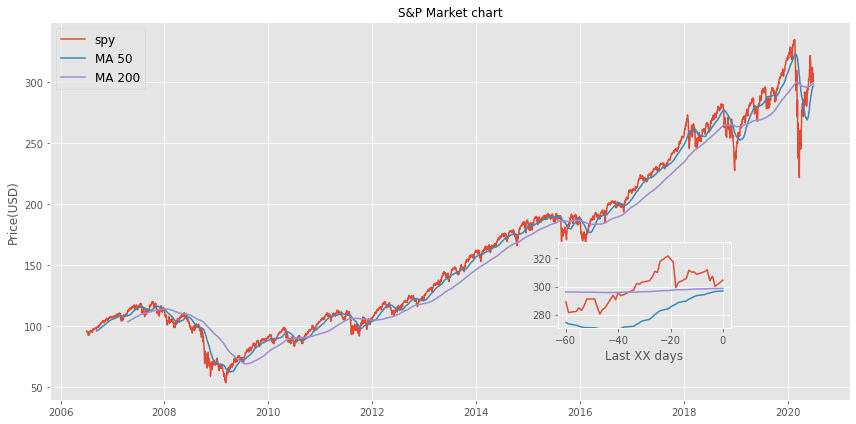

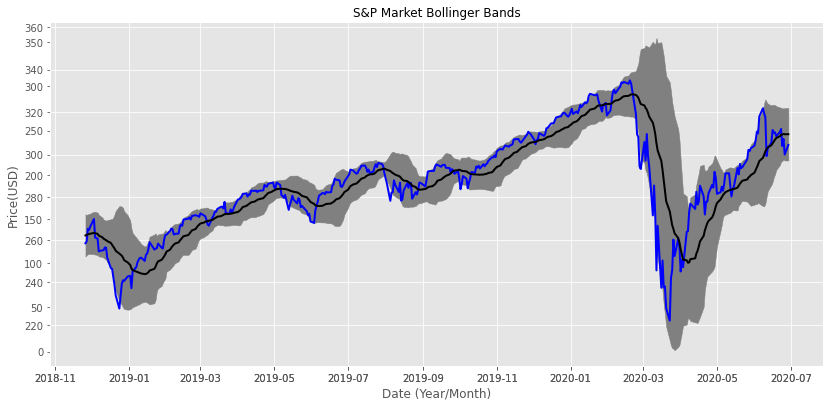

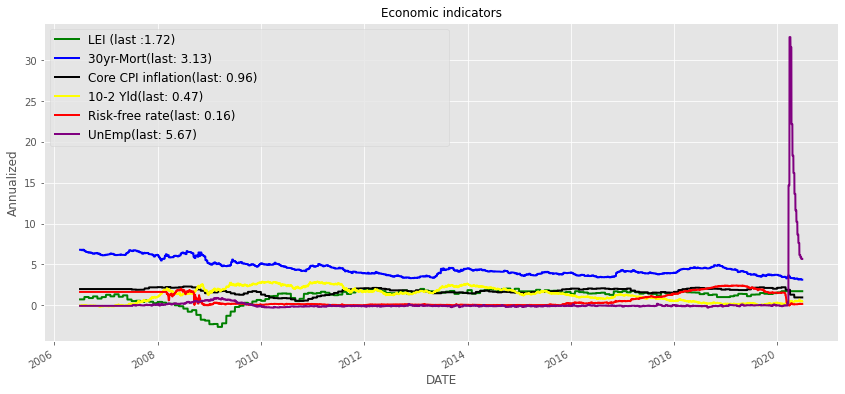

In [4]:
# Relative strength indicator and economic indicators

# Local variables
accounts = ['sectors','inx']
data_type='Adj Close'
force_update = False # Force download of financial data

for account in accounts: 
    prices_file = MAIN_FOLDER+META_FILE_FOLDER+'prices_'+account+'.csv'
    if account == 'sectors': 
        securities = ['xlp', 'xle', 'xlv', 'xli', 'xlb',
                      'xlk', 'iyt', 'xlu', 'vcr', 'vfh', 'vnq']
        
        sector_price_data = get_prices(securities, account, prices_file, 
                                       data_type, start_date, force_update)
    if account == 'inx':
        securities = [INX]
        inx_price_data = get_prices(securities,
                                    account, prices_file,
                                    data_type, start_date,
                                    force_update)
        inx_price_data['MA50_index']=inx_price_data[INX].rolling(50).mean()
        inx_price_data['MA200_index']=inx_price_data[INX].rolling(200).mean()
        inx_price_data.index = pd.to_datetime(inx_price_data.index)

#  Function calls
Market_indicator_signal,mkt_ind = get_mkt_indicator(inx_price_data)
Average_return = _1_3_6_9_12_month_returns(sector_price_data)
FRED_data_mort = get_FRED_data('MORTGAGE30US','mort',start_date,0,1,FRED_API)
FRED_data_LEI = get_FRED_data('USSLIND','LEI',start_date,0,1,FRED_API)
FRED_data_inf = get_FRED_data('CPILFESL','inf',start_date,12,100,FRED_API)
FRED_data_10_2 = get_FRED_data('T10Y2Y','10_2',start_date,0,1,FRED_API)
FRED_data_RF = get_FRED_data('DTB3','RF',start_date,0,1,FRED_API)
FRED_data_ICSA = get_FRED_data('ICSA','UnEmp',start_date,52,1,FRED_API)

if len(FRED_API) == 0:
    print('')
    print(' YOU DON''T HAVE A FRED API. THE FRED DATA'
          ' WILL NOT UPDATE UNTIL ONE IS PRESENT.'
          ' THERE ARE INSTRUCTIONS IN THE PRE-REQUISITES.')
combined_12_mo_return = pd.concat([FRED_data_RF, FRED_data_inf,
                                  FRED_data_LEI, FRED_data_mort,
                                  FRED_data_10_2, FRED_data_ICSA], 
                                  axis=1, sort=False)
combined_12_mo_return = combined_12_mo_return.fillna(method='ffill')
combined_12_mo_return = combined_12_mo_return.fillna(method='bfill')

#  Display
display = display_relative_strength(Average_return,
                                    Market_indicator_signal,
                                    mkt_ind,
                                    Securities_file_location)
display2 = prepare_market_indicator(inx_price_data,INX);
display3 = bollinger_bands_graph(inx_price_data,INX);
display4 = econometric_graph(combined_12_mo_return);

In [5]:
FRED_API = ""
not(len(FRED_API) == 0)

False